# Required packages
The packages that are needed for our symbol recognition software are:
- opencv-python
- numpy
- matplotlib
- imutils
- glob
- random
- regex
- pandas

Please make sure to download all these packages before using the notebook

In [78]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pdfminer
import pytesseract
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial import distance_matrix
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
from pdfminer.layout import LAParams
from pdfminer.converter import PDFPageAggregator
from pytesseract import Output
from pdf2image import convert_from_path

# Preparing the templates and graph

Make sure to cut templates of all the symbols that you want to detect. Choosing a descriptive and unique name for the templates is adviced so that the list with the returned counts contains practical information. The templates and graph should be saved in a .png format. All the templates should be placed in the folder that is named: 'Templates'. The graph that we want to inspect should be placed in the same folder as this notebook.

Templates should only contain the needed symbol and no, or as less as possible, other neighbouring characters or symbols.

# The software for template matching

The next codebox will iterate trough all the templates in the 'Temlates' folder and uses template matching to recognize the symbols. It will create a resulting image where boxes have been drawn around detected symbols. This image will be called 'out.png' and is placed in the same folder as this notebook.

In [91]:
class TemplateMatcher():
    """Initiate a class with a template directory and a certain diagram,
       you want to use the templates on."""
    def __init__(self, template_dir, diagram, detection_rate=0.8,
                    scale_min=1.0, scale_max=1.0, num_of_scales=1,
                    rotation=False):
        self.template_dir = template_dir
        self.diagram = diagram
        self.template_names = []
        # this variable handles the threshold of detection
        self.detection_rate = detection_rate
        # these variables handle the scale on which the template matcher looks
        self.scale_min = scale_min
        self.scale_max = scale_max
        self.num_of_scales = num_of_scales
        # this variable checks whether the template matcher needs to check
        # the four possible 90 degree rotations
        self.rotation = rotation
        # for storing the labels and label bounding boxes
        self.labels = []
        self.labels_bbox = np.empty((0, 6))
        # pdf scale
        self.pdf_scale_height = 0
        self.pdf_scale_width = 0

    
    def match_templates(self):
        """Main function. Finds all template png files and matches them with 
        the diagram. It then finds the labels belonging to these found symbols.
        """

        # convert pdf to image
        self.image_rgb = np.asarray(convert_from_path(self.diagram, 500)[0])

        image_gray = cv.cvtColor(self.image_rgb, cv.COLOR_BGR2GRAY)
        template_nr = 0
        match_collection = np.empty((0, 8))

        for file in glob.iglob(self.template_dir + '/*.png'):
            # read the templates in grayscale
            template = cv.imread(file, cv.IMREAD_GRAYSCALE)
            self.template_names.append(file.split('/')[-1])
            # check on different scales if applicable
            for scale in np.linspace(self.scale_min, 
                                        self.scale_max, self.num_of_scales):
                # get the resized template on desired scale
                w = int(template.shape[1] * scale)
                h = int(template.shape[0] * scale)
                resized_template = cv.resize(template, (w, h))
                # match the template on the diagram
                all_matches = cv.matchTemplate(image_gray, resized_template,
                                                cv.TM_CCOEFF_NORMED)
                threshold_matches = np.where(all_matches > self.detection_rate)

                # make a zip of points where matches occurred
                points = zip(*threshold_matches[::-1])

                # save the template matches in a numpy matrix
                # the last two are the center points of the bounding boxes
                # we need this later on to calculate distance between the
                # labels and symbols
                for x, y in points:
                    match_strength = all_matches[y][x]
                    match = np.array([x, y, w, h,
                                        match_strength, template_nr,
                                        x+(w/2), y+(h/2)])
                    match_collection = np.vstack([match_collection, match])

            template_nr += 1

        if not match_collection.any():
            return
        
        # create a distance matrix based on euclidean distance between points
        distance_m = linkage(match_collection[:, :2])
        # create clusters of points found in template matching
        clusters = np.array([fcluster(distance_m, t=25.0, criterion='distance')])
        # stack these clusters to the points
        match_collection = np.hstack([match_collection, clusters.T])
        match_no_duplicates = np.empty((0, 8))
        # for every cluster, find the best suitable match based on match_strength
        # which was calculated earlier
        for cluster in np.unique(clusters[0]):
            # find the matches that belong to a certain cluster
            cluster_matches = match_collection[match_collection[:, -1] == cluster]
            # for these matches, find the one with the strongest match
            best_match = np.argmax(cluster_matches[:, 2])
            # stack these into a new matrix, ignore last column, clusters 
            # do not matter anymore
            match_no_duplicates = np.vstack([match_no_duplicates, 
                                    cluster_matches[best_match, :8]])
        
        # create rectangles around the templates for our matches
        np.apply_along_axis(self.place_rect, 1, match_no_duplicates, (255, 0, 0))

        # extract the labels in the diagram through PDF extraction
        self.label_extraction(self.image_rgb.shape)

        # get the center of the bounding box for each label and template      
        if self.labels:
            label_center = self.labels_bbox[:, 4:]
            match_center = match_no_duplicates[:, 6:]
            # find the closest labels with a distance matrix
            distances = distance_matrix(match_center, label_center)
            d = np.argmin(distances, axis=1)
            # create rectangles for the labels
            np.apply_along_axis(self.place_rect, 1, self.labels_bbox[d], (0, 0, 255))
            # filter labels to closest labels foundjpg
            self.labels = np.array(self.labels)[d]
        else:
            # if label extraction did not work, then recognize labels with OCR
            for match in match_no_duplicates:
                x = int(match[0])
                y = int(match[1])
                w = int(match[2])
                h = int(match[3])
                
                # check label in 70 by 70 area around the template
                if y - 70 > 0 and y+h+70 < image_gray.shape[0] \
                        and x - 70 > 0 and x+h+70 < image_gray.shape[1]:
                    label, label_box = self.label_OCR(image_gray[y-70: y+h+70, x-70:x+h+70], 
                                                                     (x-70, y-70))
                    
                    self.labels.append(label)
                    if label_box:
                        self.place_rect(label_box, (0, 0, 255))
        
        # get the count for how often a template was found
        templates, counts = np.unique(match_no_duplicates[:, 5], return_counts=True)
        
        # deal with the templates that were not found, insert 0 as placeholder
        for number in range(0, template_nr):
            if number not in templates:
                counts = np.insert(counts, number, 0)
                
        cv.imwrite('out.png', self.image_rgb)
        # 1. Return the names of the templates, 2. The number of times a template has occured,
        # 3. The location of the templates, 4. The labels corresponding to the templates
        # 5. The found templates
        return self.template_names, match_no_duplicates[:, :2], \
                    counts, self.labels, match_no_duplicates[:, 5]
    

    def place_rect(self, bbox, color):
        """This function places rectangles on the image"""
        x = int(bbox[0])
        y = int(bbox[1])
        w = int(bbox[2])
        h = int(bbox[3])
        cv.rectangle(self.image_rgb, (x, y), (x + w, y + h), color, 2)


    def label_OCR(self, img_section, loc):
        results = pytesseract.image_to_data(img_section,
                                             output_type=Output.DICT)

        # make sure that all values of the confidence column are integers
        vector = np.vectorize(int)
        conf = np.array(results['conf'])
        conf = vector(conf)

        # list of indexes where the confidence is higher than 20
        index = np.where(conf > 20)
        
        # make sure that the texts are longer than 2 characters
        mylen = np.vectorize(len)
        lenghts = mylen(results['text'])
        index2 = np.where(lenghts>2)
        
        indexes = set(index[0]).intersection(index2[0])

        # starting distance
        min_dist = 99999
        # middle of the symbol
        mid = np.array([img_section.shape[0]/2, img_section.shape[1]/2])

        for i in indexes:
            top = results['top'][i]
            height = top + results['height'][i]
            left = results['left'][i]
            width = left + results['width'][i]
            # calculate the middle of the label
            mid_lab = np.array([(top+height)/2, (left+width)/2])
            # distance form middle of the label to middle of symbol
            dist = np.linalg.norm(mid-mid_lab)

            # check if distance is smaller than minimal distance
            if dist < min_dist:
                min_dist = dist
                label = results['text'][i]
                # return label box
                label_box = (loc[0]+left, loc[1]+top, loc[0]+ width, loc[1]+height)

        if 'label' in locals():
            return label, label_box
        else:
            return 'Not found', None
    

    def label_extraction(self, img_shape):
        """This function is recognitionused for label extraction in text extractable pdf
        files. If this does not work, use the OCR method."""
        pdf = open(self.diagram, 'rb')

        # Create a PDF parser object associated with the file object.
        parser = PDFParser(pdf)

        # Create a PDF document object that stores the document structure.
        # Password for initialization as 2nd parameter
        document = PDFDocument(parser)

        # Check if the document allows text extraction. If not, abort.
        if not document.is_extractable:
            raise PDFTextExtractionNotAllowed

        # Create a PDF resource manager object that stores shared resources.
        rsrcmgr = PDFResourceManager()

        # Create a PDF device object.
        device = PDFDevice(rsrcmgr)

        # BEGIN LAYOUT ANALYSIS
        # Set parameters for analysis.
        laparams = LAParams(detect_vertical=True)#detect_vertical=True)

        # Create a PDF page aggregator object.
        device = PDFPageAggregator(rsrcmgr, laparams=laparams)

        # Create a PDF interpreter object.
        interpreter = PDFPageInterpreter(rsrcmgr, device)

        page = next(PDFPage.create_pages(document))

        # calculate the scale to which the image has resized
        self.pdf_height = page.mediabox[2]
        self.pdf_width = page.mediabox[3]
        # self.page_center
        self.pdf_scale_height = img_shape[0] / self.pdf_height
        self.pdf_scale_width = img_shape[1] / self.pdf_width
        
        # read the page into a layout object
        interpreter.process_page(page)
        layout = device.get_result()

        # extract text from this object
        self.parse_obj(layout._objs)
    
    
    def parse_obj(self, lt_objs):
        """This is part of the text extraction. It parses all the found text in
        the pdf and extracts the location of the labels."""
        # loop over the object list
        for obj in lt_objs:
            # if it's a textbox, print text and location
            if isinstance(obj, pdfminer.layout.LTTextBoxHorizontal):
                x0, y0_bottom, x1, y1_bottom = obj.bbox
                # The coordinates given by pdf miner are from the bottom 
                # from the page, while opencv works with a coordinate system
                # with y starting from the top
                y0 = self.pdf_height - y0_bottom
                y1 = self.pdf_height - y1_bottom

                # create a bounding box specific to pdf scale
                w = (x1-x0)*self.pdf_scale_width
                h = (y1-y0)*self.pdf_scale_height
                x0 *= self.pdf_scale_width
                y0 *= self.pdf_scale_height
                center_x = x0+(w/2)
                center_y = y0+(h/2)
                bbox = np.array([x0, y0, w, h, center_x, center_y])

                self.labels_bbox = np.vstack([self.labels_bbox, bbox])
                self.labels.append(obj.get_text().replace('\n', ' '))

            # if it's a container, recurse
            elif isinstance(obj, pdfminer.layout.LTFigure):
                self.parse_obj(obj._objs)

In [92]:
matcher = TemplateMatcher('Templates3', 'diagram_3-gedraaid.pdf', detection_rate=0.75)
try:
    template_names, location, counts, labels, templates = matcher.match_templates()
except ValueError:
    print('No matches were found in the diagram!')

[ 47  49  85  82  76  79  73  61  70  67  64  58  55 131 133 169 168 167
 166 165 164 163 162 161 160 159 158 157 156 155 154 153 152 151 150 138
 139 140 141 142 143 144 145 146 147 148 149  31]


In [86]:
pd.DataFrame({'Template Names': template_names, 'Nr. of occurrences': counts})

,Template Names,Nr. of occurrences
0,Inverter.png,0
1,Battery.png,0
2,Disconnector.png,0
3,kWh.png,0
4,Twave2.png,0
5,Transformer.png,0
6,Generator.png,0
7,M.png,0
8,Triangle.png,0
9,Twave1.png,0


In [83]:
components = []
for template in templates:
    components.append(template_names[int(template)])
pd.DataFrame({'Component': components, 'Location': location.astype(int).tolist(), 'Label': labels})

,Component,Location,Label
0,2.8.png,"[1793, 2926]",=BSL2 AHJ20 UC001 (60kVA)
1,2.8.png,"[1794, 4394]",=BSL2 ANE20 UC001
2,2.8.png,"[1794, 5853]",=BSL2 ANE50 UC001
3,2.8.png,"[2946, 3405]",ANE70 5106
4,2.8.png,"[2946, 2884]",ANE70 5101
...,...,...,...
79,2.8.png,"[2946, 4134]",AAF60 5005
80,2.8.png,"[2946, 4238]",AAF60 5105
81,2.8.png,"[2946, 4342]",AAF60 5205
82,2.8.png,"[2947, 4550]",AAF60 5405


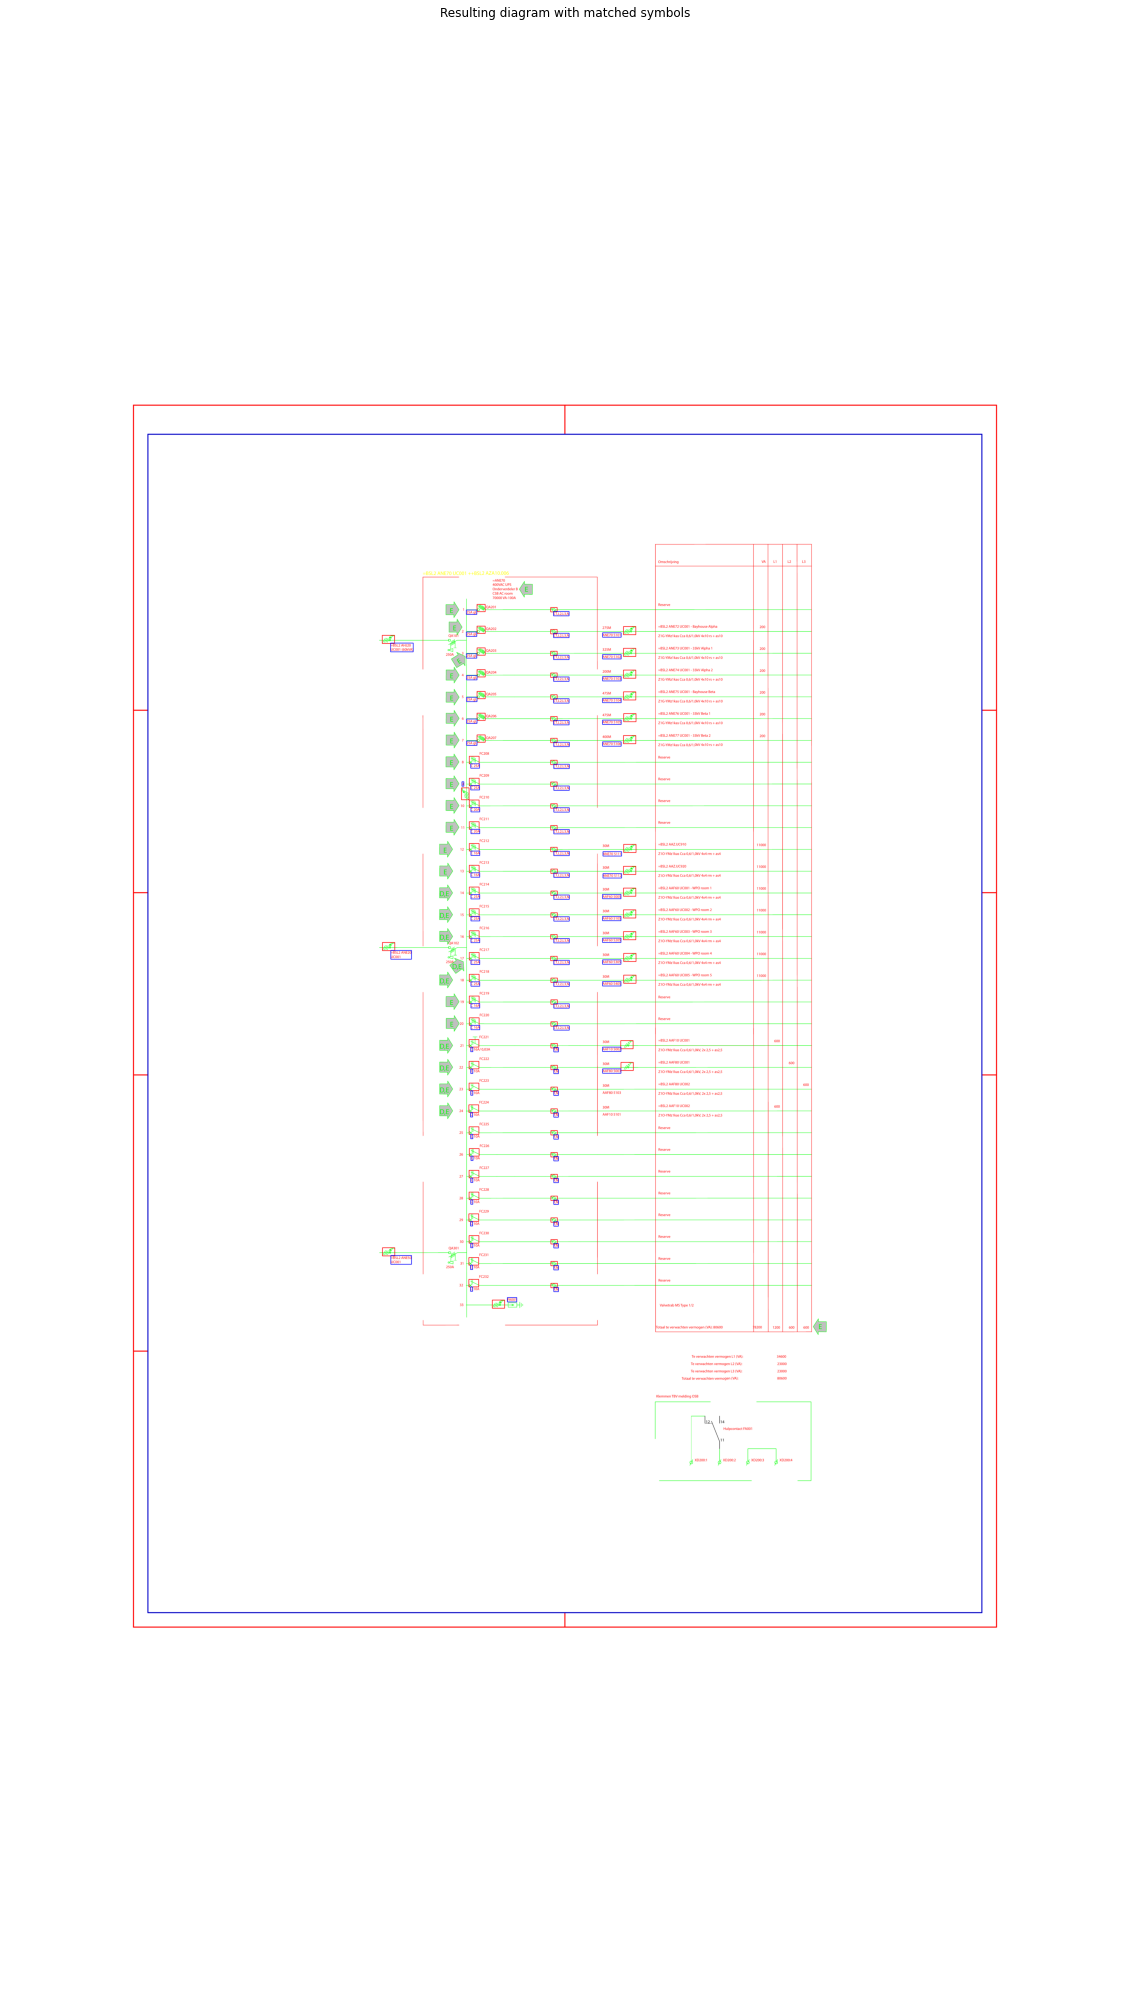

In [84]:
image_rgb = cv.imread('out.png')
plt.figure(figsize = (20,400))
plt.imshow(image_rgb)
plt.title('Resulting diagram with matched symbols')
plt.axis('off')
plt.show()